## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from tomo_encoders import Patches, DataFile
import tensorflow as tf
sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter/')
import time
from sparse_segmenter import SparseSegmenter
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes

In [2]:
# load vols here and quick look
# fpath = '/data02/MyArchive/AM_part_Xuan/data/AM316_L205_fs_tomo_L5_rec_1x1_uint16.hdf5'
# fpath_y = '/data02/MyArchive/AM_part_Xuan/CTSegNet_masks/AM316_L205_fs_tomo_L5.hdf5'

fpath = '/data02/MyArchive/AM_part_Xuan/data/mli_L206_HT_650_L3_rec_1x1_uint16.hdf5'
fpath_y = '/data02/MyArchive/AM_part_Xuan/CTSegNet_masks/mli_L206_HT_650_L3.hdf5'


X = DataFile(fpath, tiff = False, data_tag = "data", VERBOSITY = 0).read_full().astype(np.float32)
Y = DataFile(fpath_y, tiff = False, data_tag = "SEG", VERBOSITY = 0).read_full()

In [3]:
syx = slice(650,-650,None)
# sz = slice(100,-100,None)
sz = slice(None,None,None)
# view_midplanes(X[:,syx,syx])

In [4]:
X = X[sz,syx,syx]
Y = Y[sz,syx,syx]

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

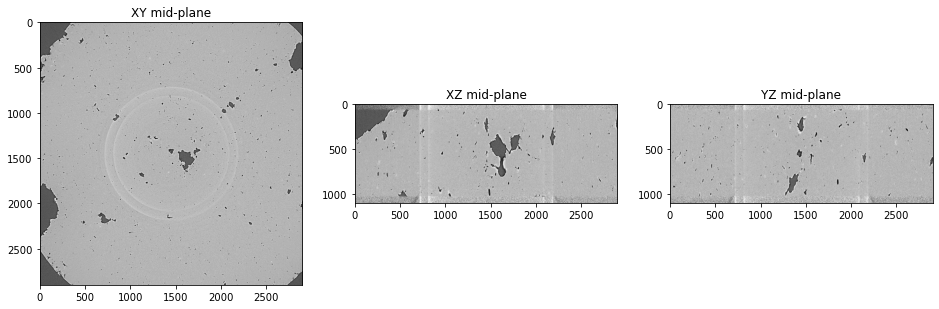

In [5]:
fig, ax = plt.subplots(1,3, figsize = (16,6))
view_midplanes(vol = X, ax = ax)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

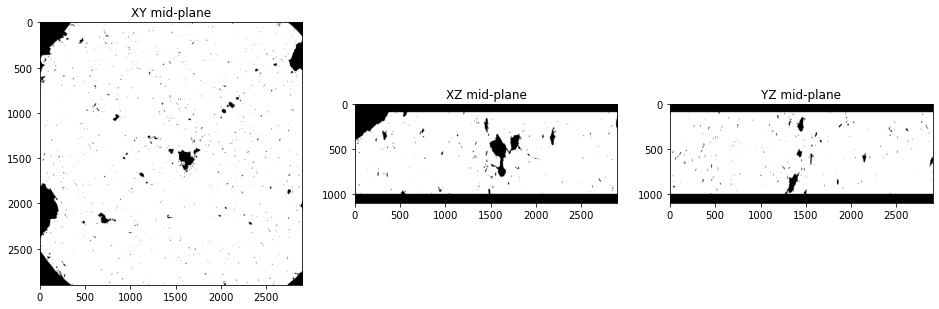

In [6]:
fig, ax = plt.subplots(1,3, figsize = (16,6))
view_midplanes(vol = Y, ax = ax)

## Test it  

In [7]:
bin_size = (64,64,64)
descriptor_tag = 'test_noblanks_pt2cutoff'
model_names = {"segmenter" : "segmenter_Unet_%s"%descriptor_tag}
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/AM_part_segmenter'

In [8]:
## Need to write the stitch function
max_stride = 4 # do reconstruction at this binning

In [10]:
fe = SparseSegmenter(model_initialization = 'load-model', model_names = model_names, model_path = model_path)

In [11]:
patches = Patches(X.shape, initialize_by = "grid", \
                  patch_size = fe.model_size, stride = max_stride)
Yp = np.zeros(X.shape, dtype = np.uint8)
Yp = fe._segment_patches(X, Yp, patches, upsample = max_stride)



Done  1 of  1

Total time for segmentation at stride 4: 63.01 seconds


In [12]:
## binning back down
sbin = slice(None,None,max_stride)
padding = [X.shape[i]%max_stride for i in range(3)]
## edge detection
Y_edge = fe._edge_map(Yp[sbin,sbin,sbin].copy())

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

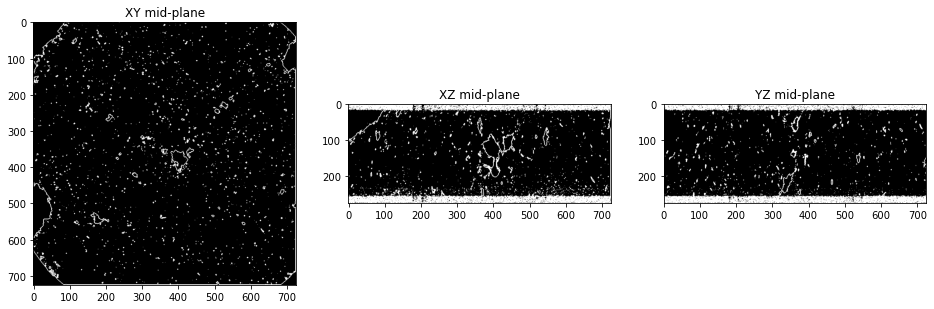

In [13]:
fig, ax = plt.subplots(1,3, figsize = (16,6))
view_midplanes(vol = Y_edge, ax = ax)

In [14]:
## select patches containing edges
new_patch_size = tuple(np.asarray(fe.model_size)//max_stride)
p_sel = Patches(Y_edge.shape, initialize_by = "regular-grid", patch_size = new_patch_size, stride = 1)

In [15]:
def plot_grid(p):
    fig, ax = plt.subplots(1,3, figsize = (20,8))

    ivals = [(0, 1, 2), (1, 0, 2), (2, 0, 1)]

    for ival in ivals:
        ip, i1, i2 = ival
        ax[ip].scatter(p.centers()[:,i1], p.centers()[:,i2])
        ax[ip].set_xlim([0, p.vol_shape[i1]])
        ax[ip].set_ylim([0, p.vol_shape[i2]])
    return

In [16]:
sub_vols = p_sel.extract(Y_edge, new_patch_size)        
tmp = (np.sum(sub_vols, axis = (1,2,3))>3).astype(np.uint8)
p_sel.add_features(tmp.reshape(-1,1), names = ['has_edges'])
p_edges = p_sel.filter_by_condition(p_sel.features_to_numpy(['has_edges']))

In [17]:
## rescale patches
p_edges = p_edges.rescale(max_stride, X.shape)

In [18]:
p_edges.points[:5]

array([[  0,   0,   0],
       [  0,   0,  64],
       [  0,   0, 128],
       [  0,   0, 192],
       [  0,   0, 256]])

In [19]:
p_edges.widths[:5]

array([[64, 64, 64],
       [64, 64, 64],
       [64, 64, 64],
       [64, 64, 64],
       [64, 64, 64]])

In [20]:
len1 = len(p_sel.points)
len0 = len(p_edges.points)
t_save = (len1-len0)/len1*100.0
print("compute time saving %.2f pc"%t_save)

compute time saving 5.68 pc


In [21]:
## segment these patches only
Yp = fe._segment_patches(X, Yp, p_edges, arr_split_infer=10)



Done 10 of 10

Total time for segmentation at stride 1: 1350.06 seconds


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

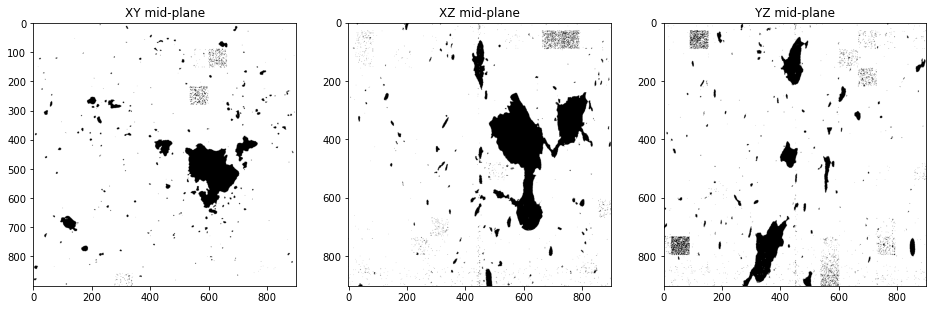

In [22]:
fig, ax = plt.subplots(1,3,figsize = (16,8))
view_midplanes(Yp[100:-100,1000:-1000,1000:-1000], ax)

In [23]:
# fig, ax = plt.subplots(1,3,figsize = (16,8))
# view_midplanes(Yp[100:-100,1000:-1000,1000:-1000], ax)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

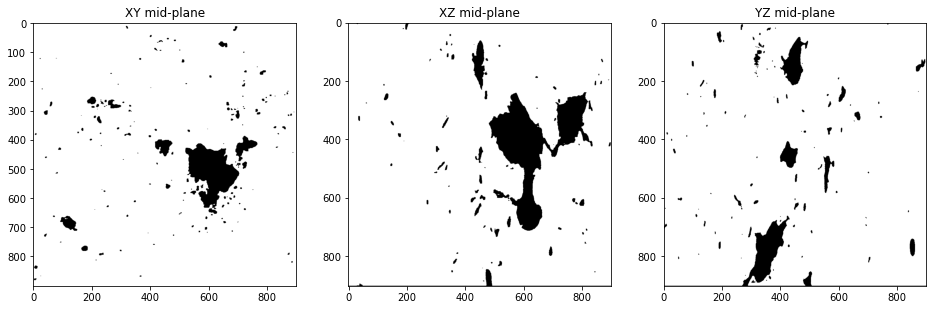

In [24]:
fig, ax = plt.subplots(1,3,figsize = (16,8))
view_midplanes(Y[100:-100,1000:-1000,1000:-1000], ax)

In [25]:
# fig, ax = plt.subplots(1,3,figsize = (16,8))
# view_midplanes(Y_pred[100:-100,1000:-1000,1000:-1000], ax)

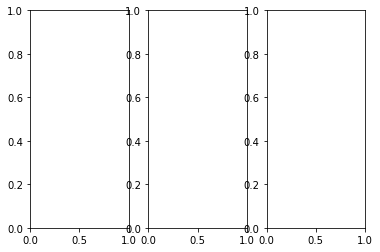

In [26]:
fig, ax = plt.subplots(1,3)
idx = 0
s = [slice(100,-100), slice(1000,-1000), slice(1000,-1000)]

# seg_plot()
# ax[idx]